# Decision Tree Classifier를 코드와 함께 좀더 자세히 살펴보는 시간입니다.


**1. 실습에서 사용할 각종 패키지들을 먼저 불러옵니다.**

*   pandas: 테이블 형태의 데이터를 처리하는 패키지
*   numpy: 행렬을 다루는 패키지
*   pyplot: 그림 그릴 때 쓰는 패키지
*   sklearn: 각종 머신러닝 알고리즘을 편리하게 쓸 수 있는 패키지 (사이킷-런)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

**2. 데이터를 읽어들입니다.**

   * 데이터 다운로드 및 설명 링크:  https://archive.ics.uci.edu/ml/datasets/heart+disease

In [ ]:
df = pd.read_csv('processed.cleveland.data', header=None)    # header = None : 데이터의 변수 이름을 텍스트로 나타내는 header 부분이 따로 없는 상태를 그대로 읽어들입니다.

**3. 읽어들인 데이터를 확인해봅니다.**

In [ ]:
df.head()     # 테이블의 가장 위 5개(default 값) 행을 봅니다.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


**4. 데이터 설명 링크를 참조하며 각 칼럼에 이름을 붙여줍니다.**

   * 데이터 설명 링크 (재방송):  https://archive.ics.uci.edu/ml/datasets/heart+disease

In [ ]:
df.columns = ['age',
              'sex',
              'cp',
              'restbp',
              'chol',
              'fbs',
              'restecg',
              'thalach',
              'exang',
              'oldpeak',
              'slope',
              'ca',
              'thal',
              'hd']

df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


**5. 데이터 테이블이 일단 모양새를 갖춘 듯한데, 누락된 값(결측치)이 있는지 살펴봐야 하기 때문에, 아래와 같은 작업으로 각각의 값이 어떠한 형태로 있는지 알아봅니다.**

In [ ]:
df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

   * 다른 칼럼들은 float64(소수)인데 'ca' 칼럼과 'thal' 칼럼만 object라는 점에서, 뭔가 이 두 칼럼에는 숫자가 아닌 문자라든가 다른 형태의 자료가 섞여있다는 점을 유추할 수 있습니다.

**6. 이럴 때에는 아래와 같이 한 번 해당 칼럼의 고유한 값, 즉 값의 종류에는 어떤 것들이 있는지 살펴보는 것이 방법입니다.**

In [ ]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)



*   0, 1, 2, 3, 그리고 '?'라는 값이 있다는 점을 확인할 수 있습니다. 바로 이 '?' 기호가 있는 것이 문제였던 것입니다.
*   아래의 'thal' 칼럼도 마찬가지입니다.



In [ ]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

**7. 이처럼 값을 알 수 없는 결측치가 존재할 때, 접근 방법은 두 가지입니다.**

1.   해당 결측치와 관련된 자료를 모두 삭제하기
2.   결측치의 값이 무엇이었을지 예측해서 채워넣기

**어느 방향으로 접근해야 할지 알아보기 위해서 우선 사이즈가 얼마나 큰지 파악해봅니다.**

In [ ]:
len(df.loc[(df['ca']=='?')  |  (df['thal']=='?')])

6

*   length 라는 파이썬 내장함수를 써서 'ca' 칼럼에 ? 기호가 있거나 'thal' 칼럼에 ? 기호가 있는 모든 데이터의 개수를 알아보니, 단 6개만 존재한다는 점을 확인할 수 있습니다.


**8. 결측치의 개수가 적다는 사실에 안심하고 아래와 같이 실제 해당 데이터를 '모두'(6개뿐이므로) 열람해봅니다.**

In [ ]:
df.loc[(df['ca']=='?')  |  (df['thal']=='?')]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


**9. 그런데 혹시나 전체 데이터의 개수가 얼마나 되는지도 알아볼 필요가 있으므로 아래와 같이 전체 데이터의 크기를 알아봅니다.**

In [ ]:
len(df)

303

In [ ]:
(6/303)*100

1.9801980198019802



*   무려 303개의 데이터가 존재하는데, 결측치가 존재하는 데이터는 단 6개이므로, 결측치가 있는 데이터(전체의 약 2%에 불과)는 제거해야겠다고 마음을 굳힐 수 있습니다.



**10. 결측치가 없는 데이터들로 다시 데이터를 잡습니다.**

In [ ]:
df_no_missing = df.loc[(df['ca']!='?')  &  (df['thal']!='?')]

In [ ]:
len(df_no_missing)

297



*   6개를 제거하고 나니 303-6 = 297개의 데이터가 남았음을 확인하였고,
*   아래와 같이 정말 'ca' 칼럼과 'thal' 칼럼의 고유한 값들 중에서 이제는 ? 기호가 사라졌는지 재확인해볼 수 있습니다.



In [ ]:
df_no_missing['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0'], dtype=object)

In [ ]:
df_no_missing['thal'].unique()

array(['6.0', '3.0', '7.0'], dtype=object)

**11. 이제 결측치가 없는 데이터 테이블을 변조될 걱정 없이 활용하기 위해 복제를 해서 복사본을 이용하기로 합니다. 그리고 'hd', 즉 심장 질환의 유무를 나타내는 칼럼은 따로 분리해내서 레이블(나중의 'y')로 쓸 것입니다.**

In [ ]:
X = df_no_missing.drop('hd', axis=1).copy()   # X = df_no_missing.iloc[:, :-1]          # what happens if axis = 0 ?

In [ ]:
X.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [ ]:
y = df_no_missing['hd'].copy()
y.head()

0    0
1    2
2    1
3    0
4    0
Name: hd, dtype: int64

In [ ]:
X.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
dtype: object

**12. 그런데 몇 가지 변수는 3개 이상의 categorical variable(가령, 1, 2, 3, 4로 구분된 4개의 categorical variable)입니다. 가령, 'cp'가 그렇습니다. 이런 경우, sklearn이 제공하는 모형은 대소관계(>, =, <)를 통해서 나뭇가지를 만들기 때문에 1과 2, 3과 4는 각각 묶일 수 있되, 1과 4, 2와 3이 각각 묶일 수는 없게 되는 현상이 발생합니다. 이러한 현상을 해결하기 위해서 get_dummies라는 함수를 통해 각각의 값을 독립시켜주는 작업을 합니다.**



*   이러한 작업을 하는 이유는 sklearn이 제공하는 모형에 맞춰주기 위함인데,
*   사실 결측치가 있는 데이터를 그대로 두지 않는 것, X와 y를 분리해내는 것 등 모두
*   sklearn이 제공하는 모형에 데이터를 맞춰주는 작업입니다.
*   따라서 만약 여러분께서 나무 모형을 sklearn의 도움 없이 새로 코드를 짜서 만들어내신다면,
*   지금과 같은 작업을 동일하게 수행할 필요는 없게 됩니다.


In [ ]:
X['cp'].unique()

array([1., 4., 3., 2.])

In [ ]:
pd.get_dummies(X, columns=['cp']).head()

,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,1,0,0,0
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,0,0,0,1
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,1,0
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1,0,0




*   데이터 설명 링크를 참조하면서, 다른 categorical variable에 대해서도 마찬가지의 작업을 수행해줍니다.
*   다만, 성별과 같은 변수는 데이터상 0과 1의 값만 가지고 있기 때문에 대소관계에서 발생하는 문제는 없어서 그대로 두셔도 괜찮습니다.



In [ ]:
X_encoded = pd.get_dummies(X, columns=['cp', 'restecg', 'slope', 'thal'])

X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,cp_2.0,cp_3.0,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,0,0,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,0,0,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,0,0,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,0,1,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,1,0,0,0,0,1,1,0,0,1,0,0


**13. 편의상 레이블도 두 가지로(질환의 경중을 따지지 않고, 질병이 있는 경우와 없는 경우) 구분하기로 합니다. Binary classification problem으로 만들어봅니다.**

In [ ]:
y.unique()

array([0, 2, 1, 3, 4])

In [ ]:
y_not_zero_query = y > 0

y[y_not_zero_query] = 1

y.unique()

array([0, 1])

**14. 이제 sklearn을 본격적으로 활용할 때가 왔습니다. 사실 직접 코딩하면 굉장히 오래 걸리는 일인데, 이미 만들어진 코드를 그저 가져와 사용하기 때문에 세 줄이 전부입니다. 아래와 같은 세 줄의 코드로 현재 데이터에 대한 Decision Tree가 만들어집니다.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)  
  # random_state=42는 그저 저희 모두가 동일한 결과물이 나오도록 조정해둔 것입니다. (컴퓨터의 세계에서 랜덤은 사실 없습니다.)
  # 학습 데이터/레이블와 테스트 데이터/레이블을 sklearn이 알아서 나눠줍니다. (Default상 약 75:25의 비율로 만들어줍니다.)

clf_dt = DecisionTreeClassifier(random_state=42)
  # 나무를 만들기로 선언합니다.
clf_dt = clf_dt.fit(X_train, y_train)
  # 나무에다가 학습 데이터/레이블을 집어넣습니다.   -> 나무가 만들어졌습니다!

In [ ]:
print(len(y))
print(len(y_train))
print(len(y_test))

297
222
75


**15. 이제 만들어진 나무를 그림으로도 그려봅니다. 역시 sklearn이 제공하는 기능입니다.**

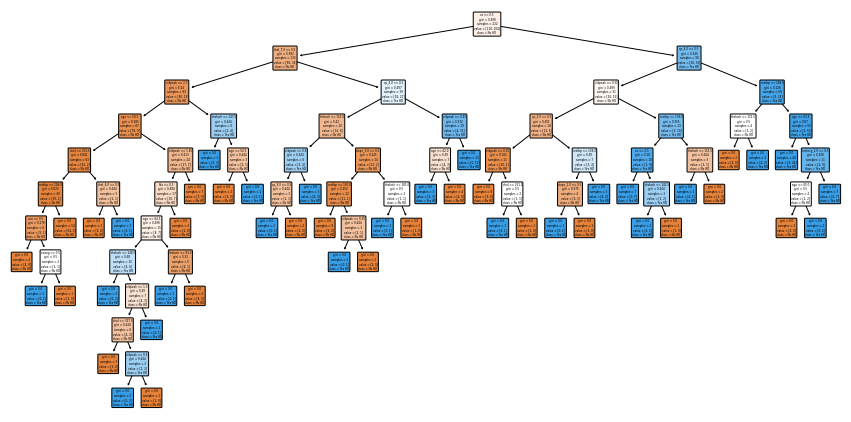

In [ ]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, filled=True, rounded=True, class_names=["No HD", "Yes HD"], feature_names = X_encoded.columns);

**16. 얼마나 잘 맞추는지 확인해보기 위해서 좀전에 만들어둔 테스트 데이터/레이블로 실험을 해보고 그림으로 나타냅니다.**


*   맞춘 것과 틀린 것을 아래처럼 표와 같은 그림으로 나타낸 것을 confusion matrix라고 부릅니다.
*   심장 질환이 없었던 사람 총 42명 중에서는 31명을 맞췄고, (약 74%)
*   심장 질환이 있었던 사람 총 33명 중에서는 26명을 맞췄습니다. (약 79%)




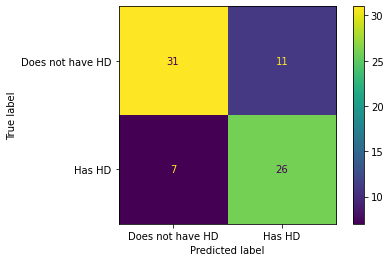

In [ ]:
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["Does not have HD", "Has HD"])

**17. 더 잘 맞출 수는 없을까요?... 나무가 너무 크고 깊으면 과적합(over-fitting) 현상이 나타나서 기존의 데이터(X_train)는 외운 듯이 잘 맞추지만, 새로운 데이터(X_test)는 곧잘 틀립니다. 그래서 나무의 크기를 좀 줄여주는 일종의 가지치기 작업을 해주면 좋은데, 0과 1 사이의 $\alpha$ 값이 있어서 이 값을 1에 가깝게 높일수록 가지를 많이 없애고, 이 값을 0에 가깝게 작게 할수록 나무의 크기를 원래대로 둔다고 합시다. 적절한 $\alpha$ 값을 찾아볼 것입니다.**

*   Cost complexity pruning이라는 방법을 써서 $\alpha$ 값이 1에 가까워질수록 가장 정보 가치가 낮은 가지부터 순서대로 없어지도록 할 것입니다.

*   역시나 sklearn에서 만들어둔 함수를 그대로 쓸 수 있습니다.

*   이 부분은 조금 어려운 내용이니, 궁금하신 분들께서는 별도로 질문을 해주시면 따로 설명을 드리도록 하겠습니다.

In [ ]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts = []

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

**18. $\alpha$ 값이 달라짐에 따라서 기존의 데이터(X_train, y_train)에 대한 예측력은 어떻게 달라지며, 새로운 데이터(X_test, y_test)에 대한 예측력은 어떻게 달라지는지 그림(시각화)을 통해 관찰해봅니다.**

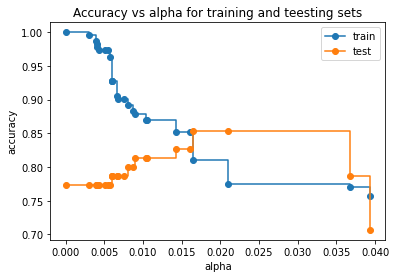

In [ ]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and teesting sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle="steps-post")
ax.legend()
plt.show()



*   나무를 자르지 않은 상태($\alpha=0$)에서는 역시 train 데이터를 외운 듯이 잘 예측하지만, 새로운 test 데이터의 예측력은 낮습니다.
*   한편, $\alpha$ 값이 커짐에 따라서 나무의 크기는 점점 작아지는데, 나무가 점차 단순해지면서 기존의 train 데이터를 설명하는 능력도 저하되지만, 오히려 test 데이터에 대한 예측력은 높아집니다.
*  결국 위의 그림에서 적절한 $\alpha$ 값은 약 0.016으로 보입니다.



**19. 한편, X_train, y_train과 X_test, y_test를 분리할 때부터 생기는 우연적 영향이 있는 상태에서, 위와 같은 단편적인 test로 $\alpha$ 값을 정하기보다는, train set을 5등분해서 Cross-Validation하여 좀더 종합적인 평가를 해서 $\alpha$ 값을 정하기로 합니다. (우선은 한 번 $\alpha$값은 그대로 0.016으로 두어봅니다.)**



*   KNN 알고리즘을 배울 때 소개해드렸던 Cross-Validation을 사용합니다.
*   마찬가지로 sklearn에서 함수를 정의해두어서 활용할 수 있습니다.
*   데이터를 총 5등분해서 test 데이터를 바꿔보는 작업인데, 다섯 번 해보니 1번째 때 예측력이 높게 나오나, 2번째, 3번째, 4번째 그리고 특히 0번째 때 예측력(55% 미만)이 매우 낮다는 점을 알 수 있습니다.
*   결국, 지금까지 찾은 0.016이라는 $\alpha$ 값은 최선의 $\alpha$ 값이 아닐 수 있는 것입니다. 



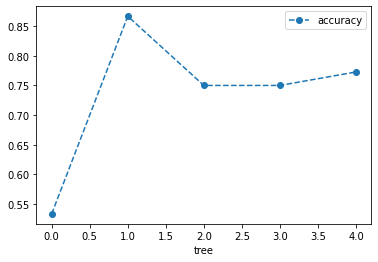

In [ ]:
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.016)

scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
df=pd.DataFrame(data={'tree':range(5), 'accuracy':scores})

df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

**20. 5등분된 데이터를 통해서 (X_train을 5등분하여 만들어낸 새로운)test 데이터를 달리 바꾸어가면서, 가장 좋은 $\alpha$ 값을 다시 찾아나갑니다. $\alpha$ 값에 대해서 5번의 예측을 평균 내어서 예측력이 가장 높은 $\alpha$ 값을 다시 찾을 것입니다.**

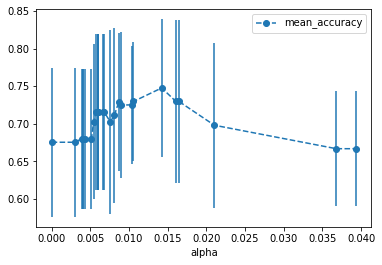

In [ ]:
alpha_loop_values = []

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
  alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha', y='mean_accuracy',yerr='std', marker='o', linestyle='--')



*   뭔가 0.011 초과 0.015 미만의 구간에서 최적의 예측력을 보이는 $\alpha$ 값이 존재한다는 점을 알 수 있습니다.
*   아래와 같이 구간을 설정하여 해당 구간에 $\alpha$ 값이 있는 행만을 뽑아냅니다.



In [ ]:
alpha_results[(alpha_results['alpha']>0.011) & (alpha_results['alpha']<0.015)]

,alpha,mean_accuracy,std
20,0.014225,0.747778,0.091395


In [ ]:
ideal_ccp_alpha = alpha_results[(alpha_results['alpha']>0.014) & (alpha_results['alpha']<0.015)]['alpha']

In [ ]:
ideal_ccp_alpha

20    0.014225
Name: alpha, dtype: float64

In [ ]:
ideal_ccp_alpha = float(ideal_ccp_alpha)

In [ ]:
ideal_ccp_alpha

0.014224751066856332

**21. $\alpha = 0.014224751066856332$일 때 실제로 예측력이 개선되는지 confusion matrix를 통해서 확인해봅니다.**

In [ ]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

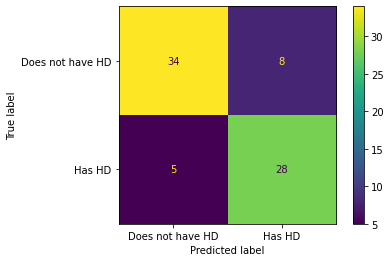

In [ ]:
plot_confusion_matrix(clf_dt_pruned, X_test, y_test, display_labels=["Does not have HD", "Has HD"])

*   심장 질환이 없었던 사람 총 42명 중에서는 (31명$\rightarrow$)34명을 맞췄고, (약 74% $\rightarrow$ 약 81%)
*   심장 질환이 있었던 사람 총 33명 중에서는 (26명$\rightarrow$) 28명을 맞췄습니다. (약 79% $\rightarrow$ 약 85%)
*   심장 질환이 없는데 있다고 오진하여 불필요한 치료로 건강에 오히려 영향을 줄 뻔했던 사람들을 3명 줄였고,
*   심장 질환이 있는데 없다고 오진할 뻔했던 사람들은 2명 줄였습니다.

**22. 마지막으로, 이렇게 가지치기를 한 결과를 그림으로도 나타내봅니다. 아까의 과적합된 나무보다는 좀더 단순하다는 점을 확인할 수 있습니다.**

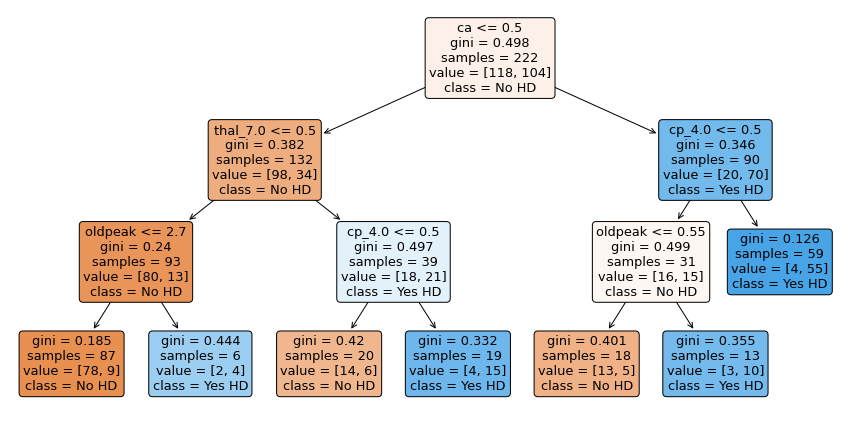

In [ ]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt_pruned, filled=True, rounded=True, class_names=["No HD", "Yes HD"], feature_names = X_encoded.columns);